In [2]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt


In [3]:
mat = scipy.io.loadmat('binaryalphadigs.mat')
data = np.array(mat['dat'])

In [4]:
# lire_alpha_digits
def read_alpha_digits(data, digits):
    """Read digits from the AlphaDigits dataset

    Parameters
    ----------
    data : np.array
    digits : List[int]
        Indexes of the digit classes to read

    Returns
    -------
    np.array
        Array of all the samples from requested digits, in binary array form 
    """    
    read_data = np.take(data.copy(), digits, axis=0)
    read_data = np.reshape(read_data, (len(digits) * read_data.shape[1]))
    return np.array(list(read_data))

# read_alpha_digits(data, [10, 11, 12])

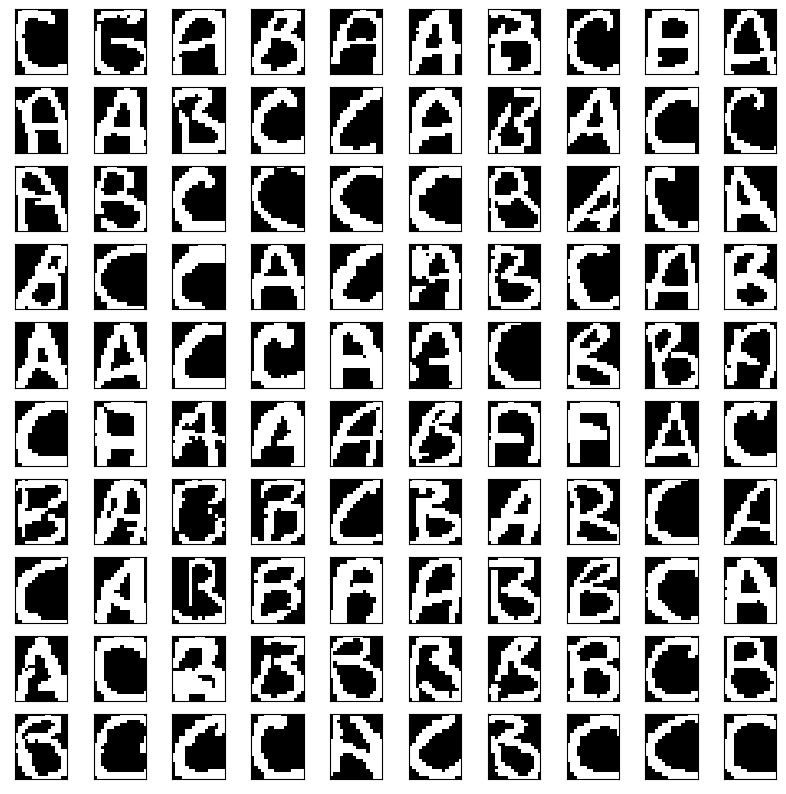

In [33]:
def display_samples(X, n_rows = 10, n_cols = 10, fig_x=10, fig_y=10):
    """
    Display a grid of samples.
    Samples are chosen randomly if there are more samples than n_rows X n_cols.
    """

    # Configs
    plt.figure(figsize=(fig_x,fig_y)) ## Create figure
    n = X.shape[0] # Obtain number of samples to display

    if n <= n_rows * n_cols: 
        # If number of samples fits in the columns/rows
        samples_idx = np.arange(n)
        if n < n_rows * n_cols:
            n_rows = n // n_cols + 1
    else: 
        # If not, choose randomly which images to show
        samples_idx = np.random.choice(n, size=n_rows * n_cols, replace=False)

    # for i in range(1, X.shape[0]):
    for k, idx in enumerate(samples_idx):
        plt.subplot(n_rows, n_cols, k+1)
        plt.imshow(X[idx], cmap=plt.get_cmap('gray'))

        # Hide ticks
        # plt.axis('off')
        plt.xticks([], [])
        plt.yticks([], [])

    plt.show()


digits = read_alpha_digits(data, [10, 11, 12])
display_samples(digits)

In [79]:
class RBM():
    def __init__(self, p, q) -> None:
        """[Restricted Boltzmann Machine](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)

        Parameters
        ----------
        p : int
            Dimensionality of each sample (width X height)
        q : int
            Hyperparameter - size of the latent variables (hidden units)
        """        
        # Initialize biases (a, b) and weight matrix (w)
        self.a = np.zeros(p)
        self.b = np.zeros(q)
        self.w = np.zeros((p, q))
        self.p = p
        self.q = q

    def encode(self, X):
        """Encode data X into latent (hidden) vector H
        n: samples per batch
        p: dimensionality of one sample (vector of observations)
        q: dimensionality of one hidden vector

        Parameters
        ----------
        X : np.array (n x p) 
            (Batch of) data to encode

        Returns
        -------
        H : np.array (n x q) 
            Latent vector
        """
        
        H = 1/ (1 + np.exp( -(X @ self.w + self.b)) )
        return H
        # pass

    def decode(self, H):
        """Decode latent (hidden) vector H into vector X
        n: samples per batch
        p: dimensionality of one sample (vector of observations)
        q: dimensionality of one hidden vector

        Parameters
        ----------
        H : np.array (n x q) 
            Latent vector to decode

        Returns
        -------
        X : np.array (n x p) 
            (Batch of) decoded data
        """
        X_rec = 1/ (1 + np.exp( -(H @ self.w.T + self.a)) )
        return X_rec
        # pass

    def train_RBM(self, x, batch_size, n_epoch=5, eps=0.1, verbose=False):
        """Train the RBM

        Parameters
        ----------
        x : np.array
            Input data, as np.ALLOW_THREADSarray of binary np.arrays
        batch_size : int
            Amount of data to be used for one gradient ascent step
        n_epoch : int, optional
            Number of epochs, by default 5
        eps : float, optional
            Learning rate, by default 0.1
        """        
        for epoch in range(n_epoch):
            if verbose: print(f"Epoch: {epoch+1}/{n_epoch}")
            # Random permutation so that the epoch is not the same at each time
            x = np.random.permutation(x)
            for batch_start in range(0, x.shape[0], batch_size):
                # if verbose: print(f"New batch with start index: {batch_start}")
                
                # Create batch
                x_batch = x[batch_start : min(x.shape[0], batch_start+batch_size)] # Deal w/ scenario of batch_size not diviser of nb_epoch
                sz_batch = x_batch.shape[0]
                
                # Initialize v0
                v0 = x_batch # sz_batch x p
                
                p_h_v0 = self.encode(v0) # sz_batch x q

                # Sample h0 from the obtained distribution p(h|v0)
                h0 = (np.random.random((sz_batch, self.q)) < p_h_v0) * 1 # sz_batch x q

                p_v_h0 = self.decode(h0) # sz_batch x p

                # Sample v1 from the obtained distribution p(v|h0)
                v1 = (np.random.random((sz_batch, self.p)) < p_v_h0) * 1 # sz_batch x p

                p_h_v1 = self.encode(v1) # sz_batch x q

                # Obtain gradients
                grad_a = np.sum(v0 - v1, axis=0) # p
                grad_b = np.sum(p_h_v0 - p_h_v1, axis=0) # q
                grad_w = v0.T @ p_h_v0 - v1.T @ p_h_v1 # p x q
                # Gradient ascent
                self.a += eps/sz_batch * grad_a
                self.b += eps/sz_batch * grad_b
                self.w += eps/sz_batch * grad_w

            # We won't evaluate the loss function, because we wouldn't be able to calculate it
            # What we do instead is to obtain the reconstruction error
            H = self.encode(x)
            x_reconst = self.decode(H)
            if verbose: print("Reconstruction error: ", np.mean(np.power(x - x_reconst, 2)))

    def generate_data(self, nb_data, nb_iter_gibbs=2, height=20, width=16):
        """
        Generate data based on Gibbs sampling
        """

        # Initialize the Gibbs sampler
        v = (np.random.random((nb_data, self.p)) < 0.5) * 1
        # We can also change the parameter of the Bernoulli at each time, to avoid bias in the initialization
        # v = (rand(p) < rand()) * 1

        for iter in range(nb_iter_gibbs):
            h = (np.random.random((nb_data, self.q)) < self.encode(v)) * 1
            v = (np.random.random((nb_data, self.p)) < self.decode(h)) * 1
            
        images = np.reshape(v, (nb_data, 20, 16))
        display_samples(images)
        return images




## Test bench

In [42]:
digits = read_alpha_digits(data, [10])

In [43]:
# display_samples(digits)
print(digits.shape)

(39, 20, 16)


In [44]:
digits_vecs = digits.reshape(39,20*16)

print(digits_vecs.shape)
# print(digits.shape)

(39, 320)


In [48]:
# ---------
# Constants
# ---------
# Data dample dim
p = 20*16 # For Binary AlphaDigits
# Latent vector dim
q = 100

rbm = RBM(p,q)
rbm.train_RBM(digits_vecs, batch_size=4, n_epoch=100, verbose=True)

Epoch: 1/200
Reconstruction error:  0.21661520375127907
Epoch: 2/200
Reconstruction error:  0.19936346727081053
Epoch: 3/200
Reconstruction error:  0.19355940973252936
Epoch: 4/200
Reconstruction error:  0.19320583140442668
Epoch: 5/200
Reconstruction error:  0.18987768757310247
Epoch: 6/200
Reconstruction error:  0.18776482295602565
Epoch: 7/200
Reconstruction error:  0.1887130568404824
Epoch: 8/200
Reconstruction error:  0.1864804681817947
Epoch: 9/200
Reconstruction error:  0.1887645897125874
Epoch: 10/200
Reconstruction error:  0.1835755219299508
Epoch: 11/200
Reconstruction error:  0.18273035904982002
Epoch: 12/200
Reconstruction error:  0.18167695007143334
Epoch: 13/200
Reconstruction error:  0.18090926302993648
Epoch: 14/200
Reconstruction error:  0.18338381333766282
Epoch: 15/200
Reconstruction error:  0.1798880728403078
Epoch: 16/200
Reconstruction error:  0.1782891567475689
Epoch: 17/200
Reconstruction error:  0.17769409961010854
Epoch: 18/200
Reconstruction error:  0.1776853

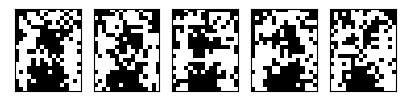

In [47]:
out = rbm.generate_data(5, nb_iter_gibbs=5)

# Analyse de l'erreur de reconstruction

In [9]:
import seaborn as sns

In [7]:
digits = read_alpha_digits(data, [10])
digits_vecs = digits.reshape(39,20*16)

<AxesSubplot:>

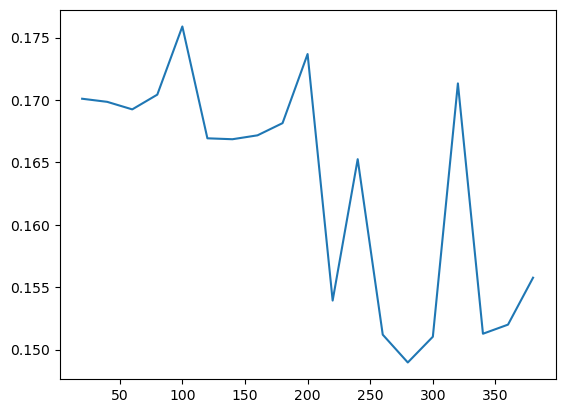

In [13]:
p = 20 * 16
errors = []
for q in range(20, 400, 20):
    rbm = RBM(p, q)
    rbm.train_RBM(digits_vecs, batch_size=4, n_epoch=100, verbose=False)
    
    errors.append(np.mean(np.power(digits_vecs - rbm.decode(rbm.encode(digits_vecs)),2)))

sns.lineplot(x=range(20, 400, 20), y=errors)

<AxesSubplot:>

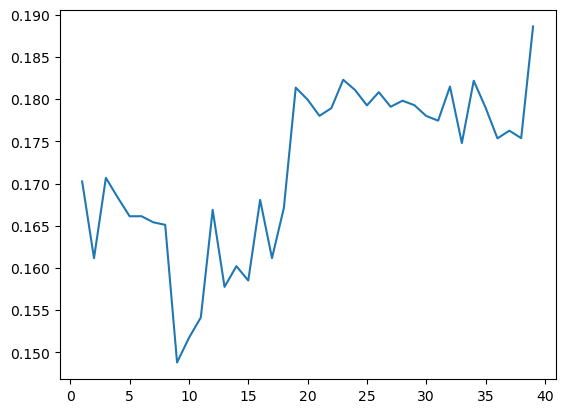

In [15]:
q = 100
errors_batch_size = []
for batch_size in range(1, 40, 1):
    rbm = RBM(p, q)
    rbm.train_RBM(digits_vecs, batch_size=batch_size, n_epoch=100, verbose=False)
    
    errors_batch_size.append(np.mean(np.power(digits_vecs - rbm.decode(rbm.encode(digits_vecs)),2)))

sns.lineplot(x=range(1, 40, 1), y=errors_batch_size)

## Analyse en fonction du nombre de caractères à apprendre

<AxesSubplot:>

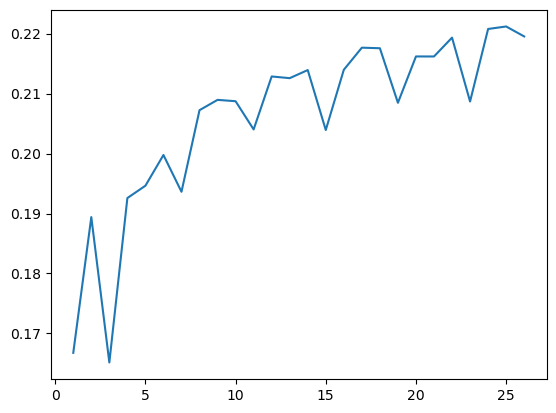

In [50]:
digits = []
p = 20*16
q = 100
errors = []
outs = []
for new_digit in range(10, len(data)):
    digits.append(new_digit)
    digits_vecs = read_alpha_digits(data, digits).reshape((-1, 20*16))

    rbm = RBM(p, q)
    rbm.train_RBM(digits_vecs, batch_size=4, n_epoch=100, verbose=False)
    errors.append(np.mean(np.power(digits_vecs - rbm.decode(rbm.encode(digits_vecs)),2)))
    #rbm.generate_data(4, nb_iter_gibbs=5)

sns.lineplot(x=range(1, len(data) - 9), y=errors)

# Analyse avec MNIST

In [65]:
from sklearn import datasets

mnist = datasets.fetch_openml('mnist_784')
# Make mnist binary
# digits = (digits > 8) * 1
# display_samples(digits.reshape((-1, 8, 8)))

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


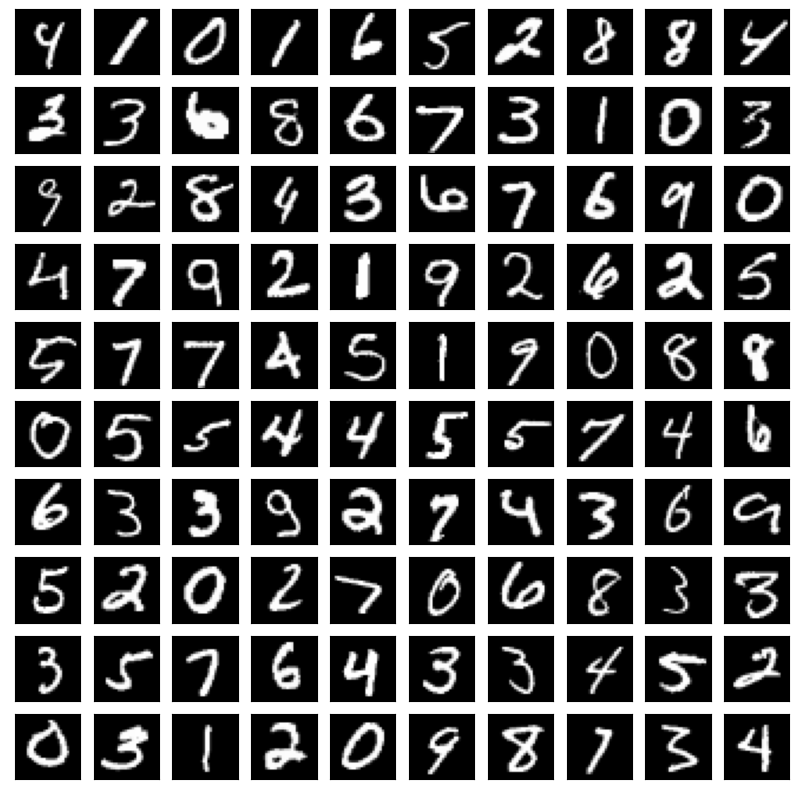

In [72]:
mnist_digits = mnist.data.to_numpy()
display_samples(mnist_digits.reshape((-1, 28, 28)))

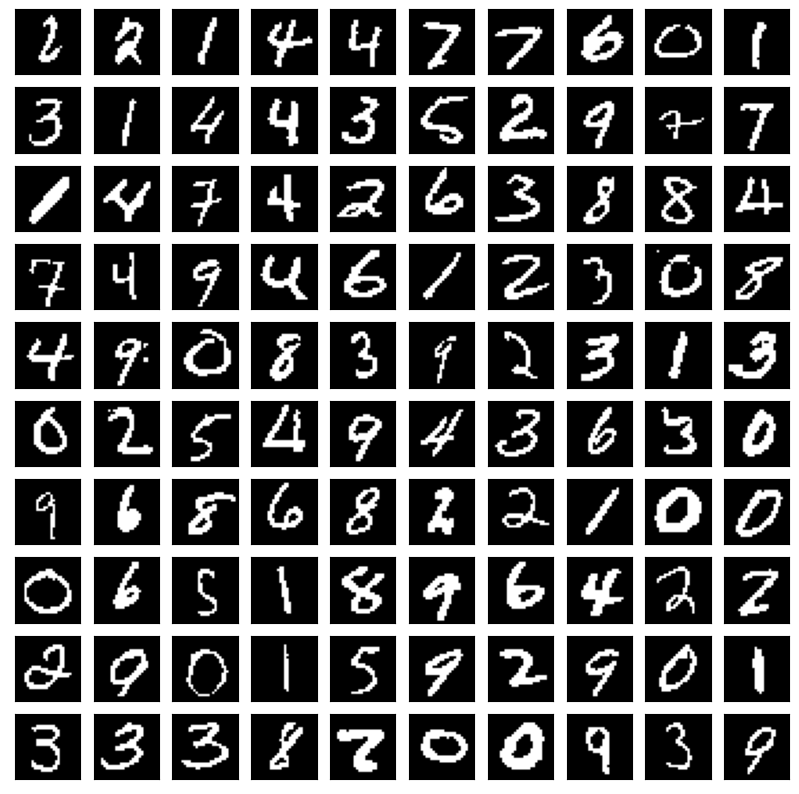

In [74]:
#Make digits binary
mnist_digits_bin = (mnist_digits > 128) * 1
display_samples(mnist_digits_bin.reshape((-1, 28, 28)))

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(mnist_digits_bin, test_size=0.3)

In [76]:
X_train.shape, X_test.shape

((49000, 784), (21000, 784))

In [80]:
# Train a RBM in MNIST
p = 28*28
q = 400
rbm = RBM(p, q)
rbm.train_RBM(X_train, batch_size=256, n_epoch=100, verbose=True)
rbm.generate_data(10, nb_iter_gibbs=10, height=28, width=28)

Epoch: 1/100
Reconstruction error:  0.08335241831578376
Epoch: 2/100
Reconstruction error:  0.08248314004920214
Epoch: 3/100
Reconstruction error:  0.08223454227214409
Epoch: 4/100
Reconstruction error:  0.08123876595040831
Epoch: 5/100
Reconstruction error:  0.08177692005386741
Epoch: 6/100
Reconstruction error:  0.08069532719281973
Epoch: 7/100
Reconstruction error:  0.0808596592682311
Epoch: 8/100
